# Прогнозирование оттока клиентов телекоммуникационной компании

Оператор связи "Ниединогоразрыва.ком" хочет научиться прогнозировать отток клиентов.

Заказчик собрал персональные данные, информацию о тарифах и договорах по некоторым клиентам. Данные собраны в четырех файлах в формате .csv

**Цель проекта**
Построить систему прогнозирования оттока клиентов, необходимо решить задачу классификации уйдет ли клиент или нет. При выяснении, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия с целью удержания клиента.

Издержки для ударжания старых клиентов меньше, чем при привлечении новых. Уменьшение оттока клиентов благоприятно скажется на прибыли и финансовых показателях компании.

Для решения проблемы необходимо построить модель прогнозирования ухода клиента. Для построения модели машинного обучения нужно выполнить следующие работы:
 - Провести исследовательский анализ собранных данных
 - Провести подготовку данных к обучению модели
 - Обучить и выбрать наиболее подходящую модель машинного обучения
 - Провести тестирование выбранной модели на тестовых данных.
 
Минимально значение метрики AUC-ROC = 0.85, при достижения этого значения проект будет считаться успешно выполненным.


## План выполнения проекта
### Загрузка данных и знакомство с общей информацией
 1. Загрузим данные и сохраним их в переменных
 2. Ознакомимся с признаками в датасетах
 3. Ознакомимся с общей информацией по датасету
 4. Посмотрим на количество по дубликатов в датасете
 5. Приведем названия столбцов к стилю *snake_case* для удобства работы
 
### Исследовательский анализ данных
 1. Объединим все датасеты в один
 2. Заполним пропуски в данных
 3. Изменим типы данных в необходимых столбцах для возможности работы с ними (например даты)
 4. Создадим столбец с целевым признаком `left`
 5. Посмотрим есть ли дисбаланс классов пользователей (ушедших и оставшихся)
 6. При необходимости создадим дополнительные признаки из уже имеющихся признаков
 7. Ознакомимся с распределением призков для каждого датасета
 8. Ознакомимся с корреляцией признаков
 
### Подготовка данных к обучению моделей
 1. Разделим данные на обучающую выборку и тестовую
 2. Выделим датасеты с целевым признаком и обучающими признаками
 3. Преобразуем категориальные признаки
 4. Отмасштабируем числовые признаки

### Обучение моделей машинного обучения
 1. Обучим модель LogisticRegression с подбором гиперпараметров
 2. Обучим модель RandomForestClassifier с подбором гиперпараметров
 3. Обучим модель CatBoostClassifier с подбором гиперпараметров
 4. Выбирем наилучшую модель на основании кросс-валидации
 5. Протестируем выбранную модель на тестовой выборке
 6. Построим ROC-кривую
 7. Построим матрицу ошибок и проанализируем
 8. Оценим важность признаков

### Подготовка отчета
Подготовим отчет с полученными результатами обучения моделей


In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from sklearn.model_selection import (
    RandomizedSearchCV, 
    cross_val_score, 
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,  
    OrdinalEncoder,
    OneHotEncoder,
)
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
# Константы
RANDOM_STATE = 70823

## Загрузка данных и знакомство с общей информацией

In [4]:
# Загрузим данные и сохраним в переменные
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')

In [5]:
def quick_look(data):
    '''Функция отображает необходимую информацию по датасету для быстрого просмотра'''
    display(data.head())
    
    print('-----------------------------------------------\nОбщая информация:')
    display(data.info())
    
    print('-----------------------------------------------\nСтатистики:')
    display(data.describe())
    
    print(f'-----------------------------------------------\nКоличество дубликатов: {data.duplicated().sum()}')


### Первое знакомство с данными

#### Датасет `contract`

In [6]:
quick_look(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


-----------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

-----------------------------------------------
Статистики:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


-----------------------------------------------
Количество дубликатов: 0


In [7]:
# Посмотрим на первые 5 из уникальных значения в столбце EndDate т.к. в первых пяти строках значение No
contract['EndDate'].unique()[:5]

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01'],
      dtype=object)

В датасете `contract` собрана общая информация по договору для каждого клиента.

Значение наименований столбцов:
 - `customerID` - индификатор клиента;
 - `BeginDate`- дата начала пользования услугами;
 - `EndDate` - дата окончания пользования услугами;
 - `Type` - тип оплаты;
 - `PaperlessBilling` - тип электронного платежного документа;
 - `PaymentMethod` - способ оплаты;
 - `MonthlyCharges` - ежемесячные траты на услуги по договору;
 - `TotalCharges` - всего потрачено денег на услуги.

Из общей информации по датасету `contract` видно, что во всех столбцах, кроме столбца `MonthlyCharge`, тип данных `object`. Необходимо перевести столбцы `BeginDate` и `EndDate` в тип данных `datetime`, но для начала нужно заменить значения `No` в столбце `EndDate` на значение **2020-02-01** (дата выгрузки датасета).

Признаки `Type`, `PaperlessBillong`, `PaymentMethod` - являются категориальными признаками.

Признак `TotalCharges` является числовым, но тип данных в датасете `object`, необходимо привести к типу данных `float`. 

Из статистик видно, что минимальный ежемесячный платеж (`MonthlyCharges`) составляет 18.25, максимальный - 118.75, средний - 64.76, медиана - 70.35 ($)

Всего в датесете 7043 записи, в датесете нет дубликатов и нет явных пропусков.

#### Датасет `personal`

In [8]:
quick_look(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


-----------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

-----------------------------------------------
Статистики:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


-----------------------------------------------
Количество дубликатов: 0


In [9]:
# Посмотрим на уникальные значения в столбце SeniorCitizen
personal['SeniorCitizen'].unique()

array([0, 1])

В датасете `personal` собраны персональные данные клиентов.

Значение наименований столбцов:
 - `customerID` - индификатор клиента;
 - `gender`- пол клиента;
 - `SeniorCitizen` - наличие пенсионного статуса по возрасту;
 - `Partner` - наличие супруга(и);
 - `Dependents` - наличие иждивенцев.

Из общей информации по датасету `personal` видно, что все признаки категориальные и во всех столбцах тип данных `object`, кроме признака `SeniorCitizen`, необходимо будет изменить тип данных на `object`

Всего в датесете 7043 записи, в датесете нет дубликатов и нет явных пропусков.

#### Датасет `internet`

In [10]:
quick_look(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


-----------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

-----------------------------------------------
Статистики:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


-----------------------------------------------
Количество дубликатов: 0


В датасете `internet` собрана информация об интернет-услугах.

Значение наименований столбцов:
 - `customerID` - индификатор клиента;
 - `InternetService`- тип подключения интернета;
 - `OnlineSecurity` - блокировка небезопасных сайтов;
 - `OnlineBackup` - облачное хранилище файлов для резервного копирования данных ;
 - `DeviceProtection` - антивирус;
 - `TechSupport` - выделенная линия технической поддержки;
 - `StreamingTV` - стриминговое телевидение;
 - `StreamingMovies` - каталог фильмов.

Все столбцы в датасете являются категориальными.

Всего в датесете 5517 записей, это означает, что не все пользователи пользуются интернет-услугами, некоторые пользуются только услугами телефонии.

В датесете нет дубликатов и нет явных пропусков.

#### Датасет `phone`

In [11]:
quick_look(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


-----------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

-----------------------------------------------
Статистики:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


-----------------------------------------------
Количество дубликатов: 0


В датасете `phone` собрана информация об услугах телефонии.

Значение наименований столбцов:
 - `customerID` - индификатор клиента;
 - `MultipleLines`- мультиканальная линия.
 
Всего в датасете 2 столбца, являются категориальными. 

Всего в датесете 6361 записей, это означает, что не все пользователи пользуются телефонией, некоторые пользуются только интернет-услугами.

В датесете нет дубликатов и нет явных пропусков.

### Переименование столбцов

Во всех датасетах названия столбцов в стиле *CamelCase* приведем все названия столбцов в стиль *snake_case* для удобства при дальнейшей работе. Для этого напишем собственную функцию.

In [12]:
def col_to_snake_case(data):
    '''Функция преобразует названия столбцов в стиль snake_case'''
    data.columns = data.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower()
    return data

In [13]:
for df in (contract, personal, internet, phone):
    df = col_to_snake_case(df)

In [14]:
# Проверим правильность работы функции
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


### Вывод по разделу
Были загружены и сохранены датасеты в переменные. Ознакомились с общей информацией в датасетах, посмотрели на типы данных, названия столбцов, так же ознакомились со статистиками по данным, посмотрели данные на наличие явных дубликатов (не обнаружено). Было выявлено, что не все абоненты пользуются одновременно пользуется интернет-услугами и телефонией. Есть абоненты которые пользуются только интернет-услугами или телефонией.

Были переименованы столбцы в датасетах в стиль *snake_case* для удобства работы в дальнейшем.

## Исследовательский анализ данных
### Изменение типов данных для дальнейшего анализа данных

#### Измнение типа данных в датасете `contract`
При приведении столбца к типу данных `float` возникла ошибка, оказалось, что некоторые есть пропуски в данных (вместо значений - пробел).

In [15]:
# Выведем строки с пропусками в столбце total_charges
contract.loc[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Из таблицы с данными видно, что пропуски возникли в связи с тем, что дата начала пользования услугами совпадает с датой выгрузки датасета, т.е. договор на оказание услуг только заключен, заполним пропуски значением из столбца `monthly_charges`.

In [16]:
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = contract['monthly_charges']

In [17]:
# Проверим правильно ли заполнились пропущенные значения
contract.iloc[[0, 488, 753, 936]]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85


In [18]:
# Приведем столбцы к типу float64
contract[['monthly_charges', 'total_charges']] = contract[['monthly_charges', 'total_charges']].astype('float64')

In [19]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


#### Изменение типа данных в датасете `personal`

Изменим тип данных в столбце `senior_citizen` на `object`

In [20]:
personal['senior_citizen'] = personal['senior_citizen'].astype('object')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


### Объединение данных

In [21]:
data = contract
for table in [personal, internet, phone]:
    data = data.join(table.set_index('customer_id'), on='customer_id')

In [22]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

### Создание новых признаков

Создадим в датасете `contract` целевой признак `left`, для обозначения ушел ли клиент, с помощью признака `end_date`.
- 1 - клиент ушел
- 0 - клиент не ушел

In [24]:
data['left'] = 1
data.loc[data['end_date'] == 'No', 'left'] = 0

In [25]:
# Проверим правильность заполнения
data.loc[400:405]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left
400,2277-AXSDC,2017-06-01,No,One year,No,Bank transfer (automatic),19.75,650.96,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
401,9442-JTWDL,2019-03-01,No,One year,No,Credit card (automatic),20.05,220.55,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
402,0979-PHULV,2014-03-01,2015-12-01,Month-to-month,Yes,Credit card (automatic),99.45,2171.99,Male,0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1
403,3067-SVMTC,2014-06-01,No,One year,No,Bank transfer (automatic),55.90,3801.20,Female,0,Yes,No,DSL,Yes,No,No,Yes,No,No,No,0
404,5495-GPSRW,2018-06-01,No,Two year,Yes,Mailed check,19.70,394.00,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
405,7606-BPHHN,2014-02-01,2018-03-01,Two year,Yes,Credit card (automatic),19.80,970.20,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1


Заменим занчения No в столбце `end_data` на дату выгрузки датасета (2020-02-01), чтобы в дальнейшем привести столбец к типу `datetime64` и дальнейшего создания нового признака длительности контракта.

In [26]:
data.loc[data['end_date'] == 'No', 'end_date'] = '2020-02-01'
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


In [27]:
data.loc[400:405]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left
400,2277-AXSDC,2017-06-01,2020-02-01,One year,No,Bank transfer (automatic),19.75,650.96,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
401,9442-JTWDL,2019-03-01,2020-02-01,One year,No,Credit card (automatic),20.05,220.55,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
402,0979-PHULV,2014-03-01,2015-12-01,Month-to-month,Yes,Credit card (automatic),99.45,2171.99,Male,0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1
403,3067-SVMTC,2014-06-01,2020-02-01,One year,No,Bank transfer (automatic),55.90,3801.20,Female,0,Yes,No,DSL,Yes,No,No,Yes,No,No,No,0
404,5495-GPSRW,2018-06-01,2020-02-01,Two year,Yes,Mailed check,19.70,394.00,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
405,7606-BPHHN,2014-02-01,2018-03-01,Two year,Yes,Credit card (automatic),19.80,970.20,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1


In [28]:
data[['begin_date', 'end_date']] = data[['begin_date', 'end_date']].astype('datetime64')

Создадим новый признак `duration` в которой будет указана длительность договора в месяцах и `duration_days` - длительность в днях.

In [29]:
data['duration'] = data['end_date']\
.dt.to_period('M').view(dtype='int64') - data['begin_date'].dt.to_period('M').view(dtype='int64')

data['duration_days'] = data['end_date']\
.dt.to_period('d').view(dtype='int64') - data['begin_date'].dt.to_period('d').view(dtype='int64')

data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,34,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,4,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0,45,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,5,153


In [30]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,34,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,4,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0,45,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,5,153


In [31]:
# Проверим типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

### Заполнение пропусков
При первом знакомстве с данными было выявлено, что не все клиенты пользуются сразу интернет услугами и телефонией, при объединении таблиц должны появиться пропуски в данных. Посмотрим на количество пропусков.

In [32]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
left                    0
duration                0
duration_days           0
dtype: int64

Заполним пропуски в данных, в датасете `phone` собраны все клиенты, которые пользуются телефонией, отличие в них только в канальности телефонии, чтобы небыло путаницы заполним пропуки в столбе `multiple_lines` таблицы `data` значением **no_phone**. 

Похожим образом поступим со столбцами из датасета `internet`, пропуски в этих столбцах заполним значением **no_internet**

In [33]:
data['multiple_lines'] = data['multiple_lines'].fillna('no_phone')

In [34]:
data[internet.columns] = data[internet.columns].fillna('no_internet')

In [35]:
# Проверим правильность заполнения
data[85:90]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration,duration_days
85,4445-ZJNMU,2019-05-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),99.30,893.70,Male,0,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,0,9,276
86,4808-YNLEU,2017-03-01,2020-02-01,One year,Yes,Bank transfer (automatic),62.15,2327.52,Female,0,Yes,No,DSL,Yes,No,No,No,Yes,No,No,0,35,1067
87,1862-QRWPE,2016-02-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,991.20,Female,0,Yes,Yes,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,48,1461
88,2796-NNUFI,2016-04-01,2020-02-01,Two year,Yes,Mailed check,19.95,917.70,Female,0,Yes,Yes,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,no_internet,No,0,46,1401
89,3016-KSVCP,2017-09-01,2020-02-01,Month-to-month,No,Mailed check,33.75,978.75,Male,0,Yes,No,DSL,No,No,No,No,Yes,No,no_phone,0,29,883


### Распределения численных признаков

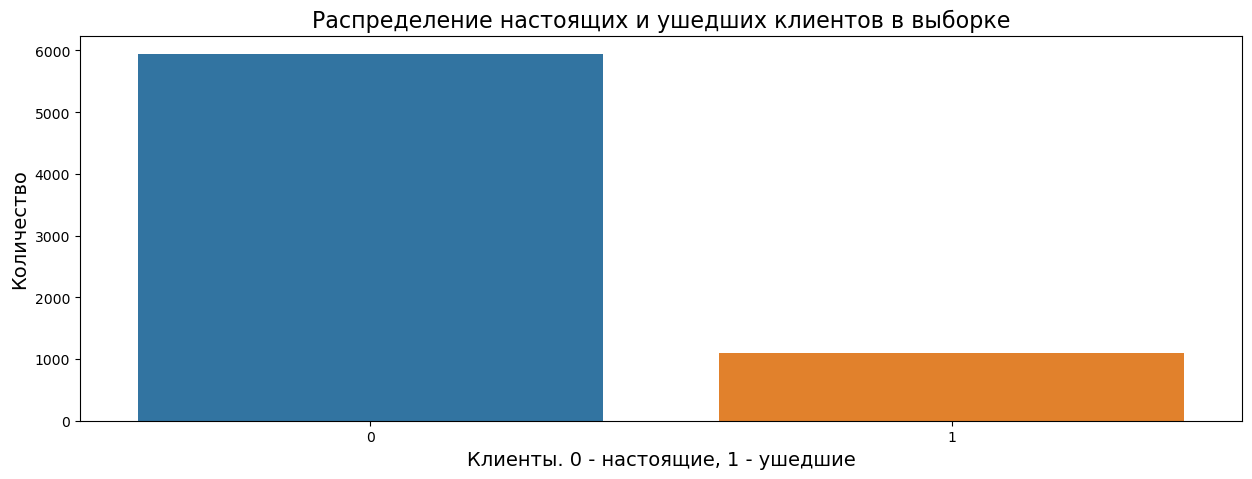

Ушедшие клиенты составляют 15.6 % от датасета


In [36]:
# Ознакомимся с дисбалансом классов
plt.figure(figsize=(15, 5))
sns.countplot(data=data, x='left')
plt.title('Распределение настоящих и ушедших клиентов в выборке', fontsize=16)
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Клиенты. 0 - настоящие, 1 - ушедшие', fontsize=14)
plt.show()

print(f"Ушедшие клиенты составляют \
{round(len(data.loc[data['left'] == 1]) / len(data) * 100, 1)} % от датасета")

Наблюдается дисбаланс классов в датасете.

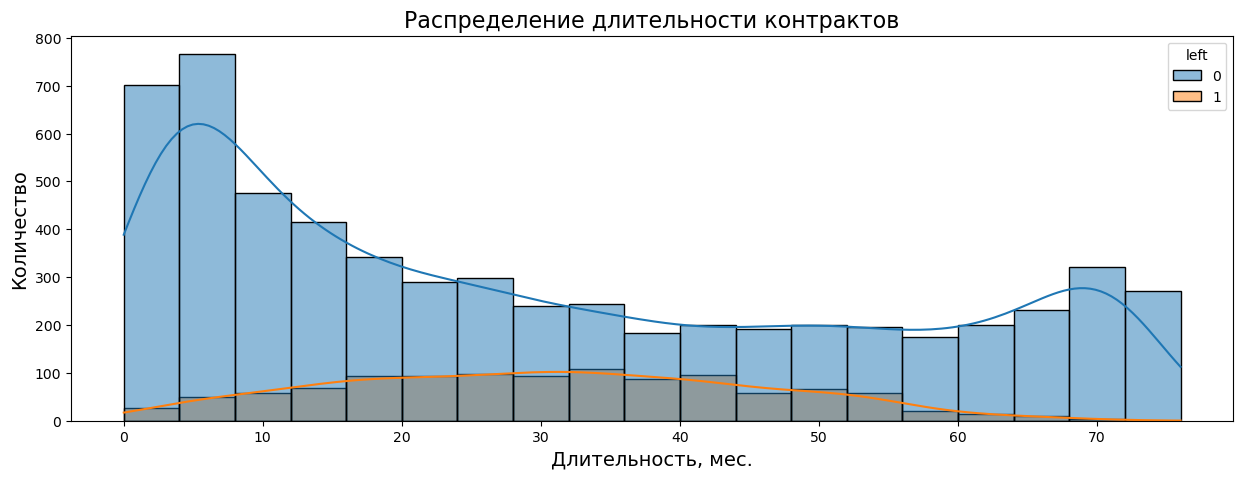

In [37]:
# Посмотрим на распределение длительности контрактов для ушедших и оставшихся клиентов
plt.figure(figsize=(15, 5))
sns.histplot(
    data=data,
    x='duration', 
    hue='left',
    kde=True,
)
plt.title('Распределение длительности контрактов', fontsize=16)
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Длительность, мес.', fontsize=14)
plt.show()

<Figure size 1500x500 with 0 Axes>

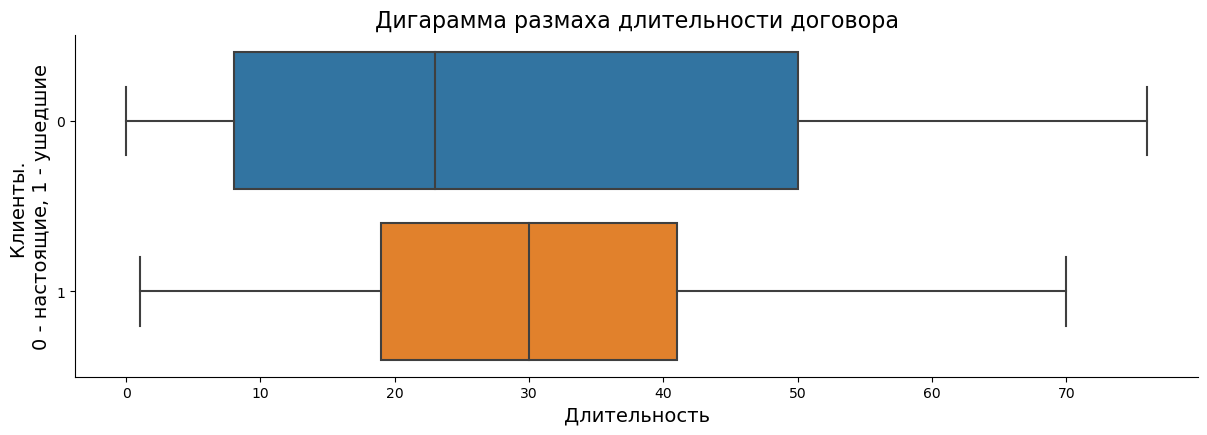

In [38]:
plt.figure(figsize=(15, 5))
plot = sns.catplot(
    data=data,
    x='duration', 
    y='left', 
    kind='box', 
    orient='h'
)
plt.title('Дигарамма размаха длительности договора', fontsize=16)
plt.xlabel('Длительность', fontsize=14)
plt.ylabel('Клиенты. \n0 - настоящие, 1 - ушедшие', fontsize=14)
plot.fig.set_figwidth(13)
plot.fig.set_figheight(4)
plt.show()

Из распределения длительности контрактов мы видим, что наибольшее количество клиентов уходят после 2 - 4 лет обслуживания. Так же можно сказать, что клиенты редко уходят после 5.5 лет обслуживания.

Видно, что среди всех абонентов большое количество новых клиентов (до 1 года). На графике можно наблюдать так же, что клиентов которые пользуются услугами компании около 7 лет больше чем клиентов, которые пользуются услугами в течении 3.5 - 6 лет. Такое распредление, возможно, связано с тем, что недавно была проведена работа по привлечению новых клиентов.

In [39]:
# Посмотрим на статистики по признаку 'duration' для ушедших пользователей
data.loc[data['left'] == 1]['duration'].describe()

count    1101.000000
mean       30.386921
std        15.073190
min         1.000000
25%        19.000000
50%        30.000000
75%        41.000000
max        70.000000
Name: duration, dtype: float64

По статистикам и графикам видно, что в среднем клиенты уходят через 30 месяцев.

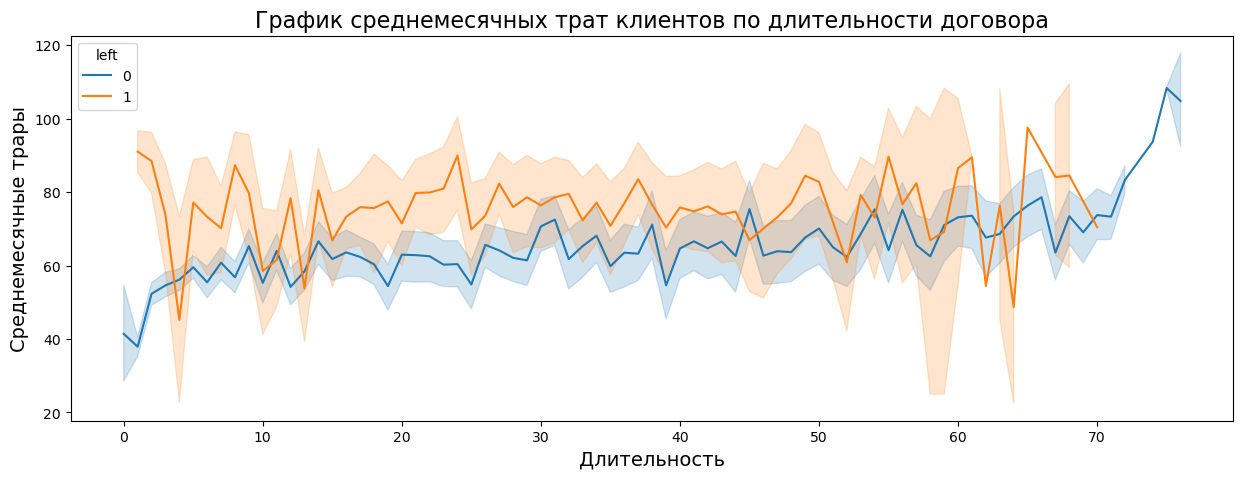

In [40]:
# Посмотрим на среднемесячные траты ушедших и текущих клиентов в зависимости от времени
plt.figure(figsize=(15, 5))
sns.lineplot(
    data=data, 
    hue='left', 
    x='duration', 
    y='monthly_charges'
)
plt.title('График среднемесячных трат клиентов по длительности договора', fontsize=16)
plt.xlabel('Длительность', fontsize=14)
plt.ylabel('Среднемесячные трары', fontsize=14)
plt.show()

<Figure size 640x480 with 0 Axes>

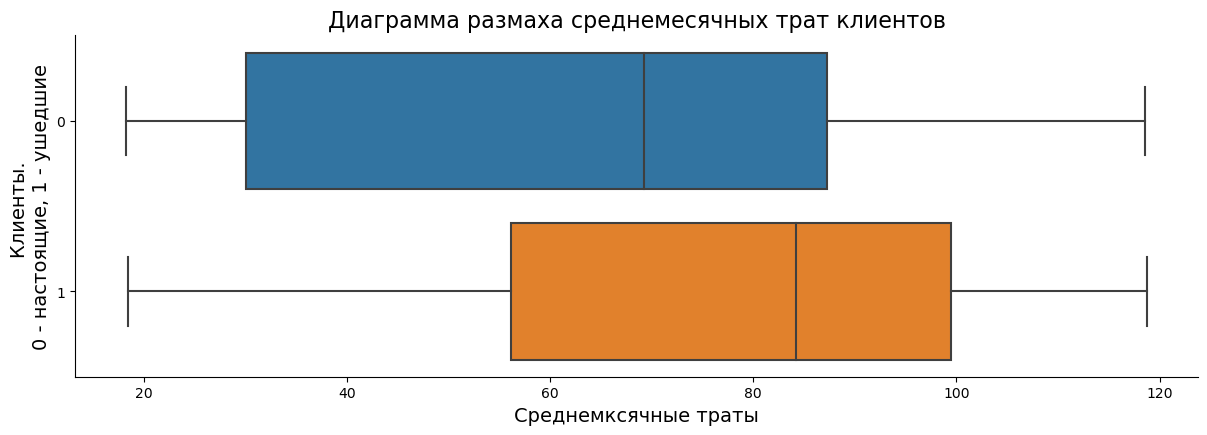

In [41]:
plt.figure()
plot = sns.catplot(
    data=data,
    x='monthly_charges', 
    y='left', 
    kind='box', 
    orient='h'
)
plt.title('Диаграмма размаха среднемесячных трат клиентов', fontsize=16)
plt.xlabel('Среднемксячные траты', fontsize=14)
plt.ylabel('Клиенты. \n0 - настоящие, 1 - ушедшие', fontsize=14)
plot.fig.set_figwidth(13)
plot.fig.set_figheight(4)
plt.show()

Из графиков по среднемесячным платам видно, что у ушедших клиентов среднемесячные платы были выше.

Из графика среднемесячных плат по договорам видно, что у ушедших клиентов в среднем ежемесячная плата примерно одинаковая, но у текущих клиентов мы видим, что лояльные клиенты чем больше они пользуются услугами телеком компании тем больше становятся их среднемесячные платы, скорее всего это связано с тем, что в течении срока действия договора клиенты подключают дополнительные услуги.

### Распределения категориальных признаков

In [42]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 
 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 
 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [43]:
def make_histplot(column):
    '''Фукнция выводит гистограмму с выделением текущих и ушедших клиентов'''
    plt.figure(figsize=(12, 4))
    plt.title(f'Распределение признака "{column.upper()}"')
    sns.histplot(
        data=data, 
        x=column, 
        hue='left'
    )
    plt.show()

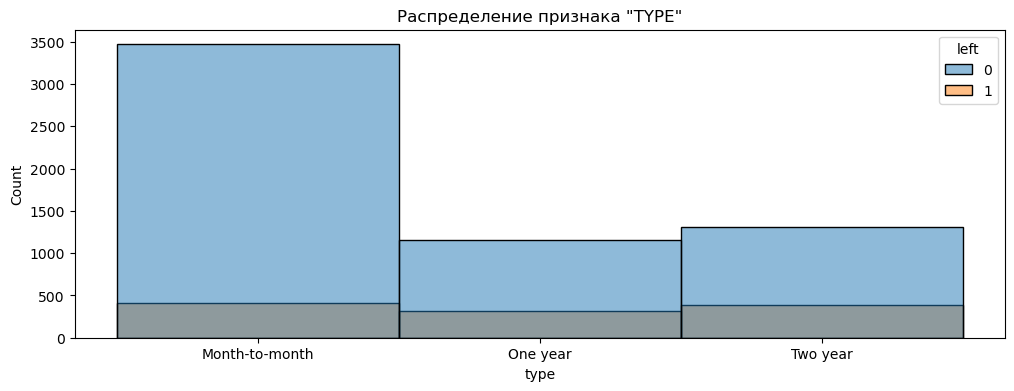

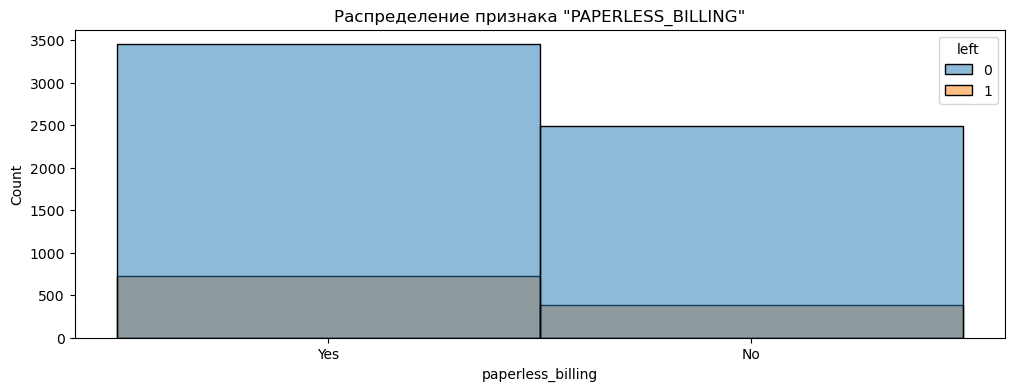

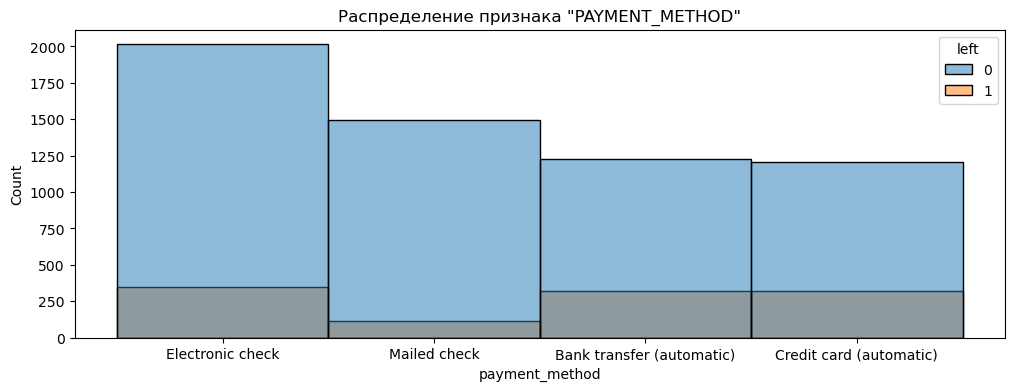

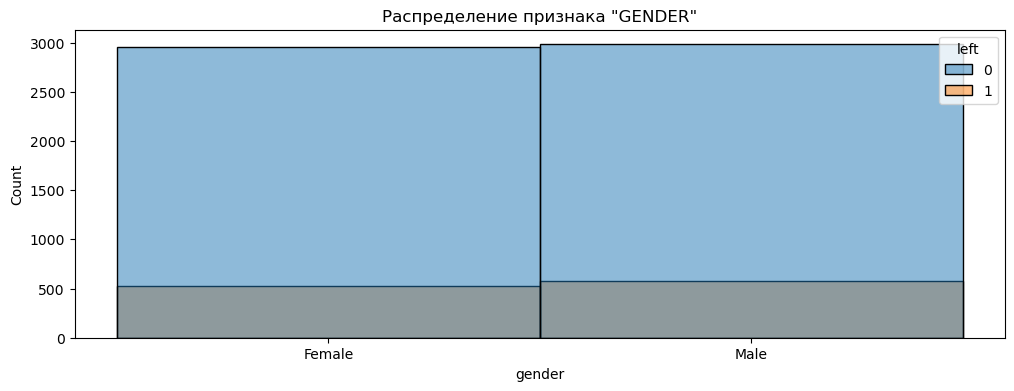

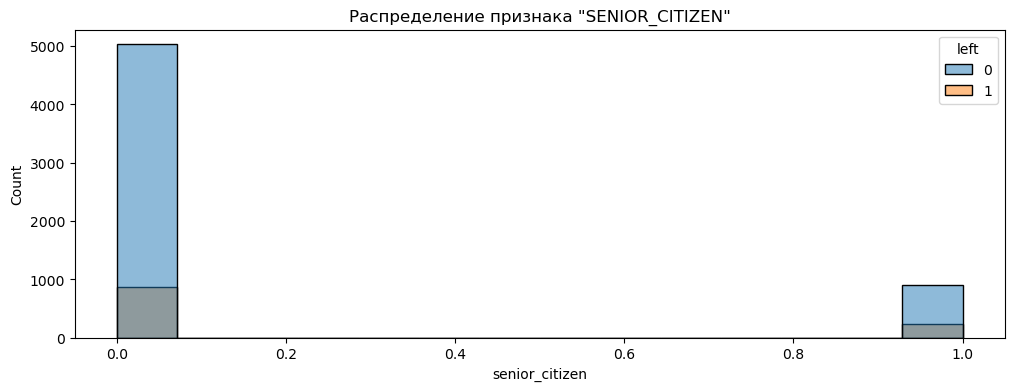

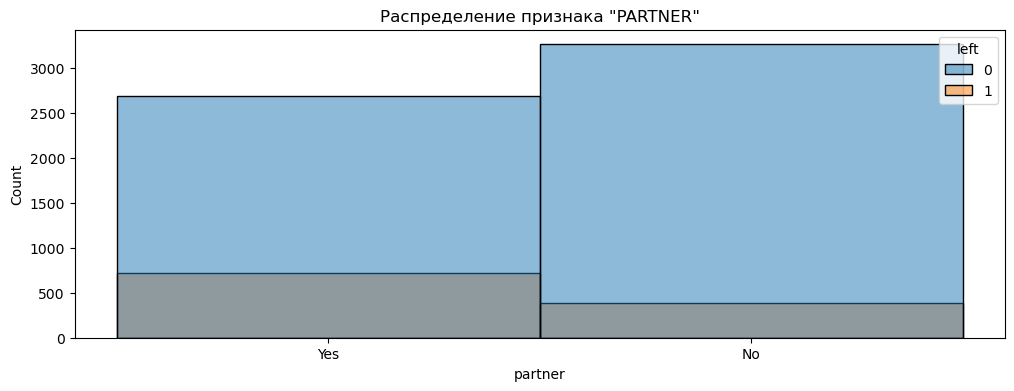

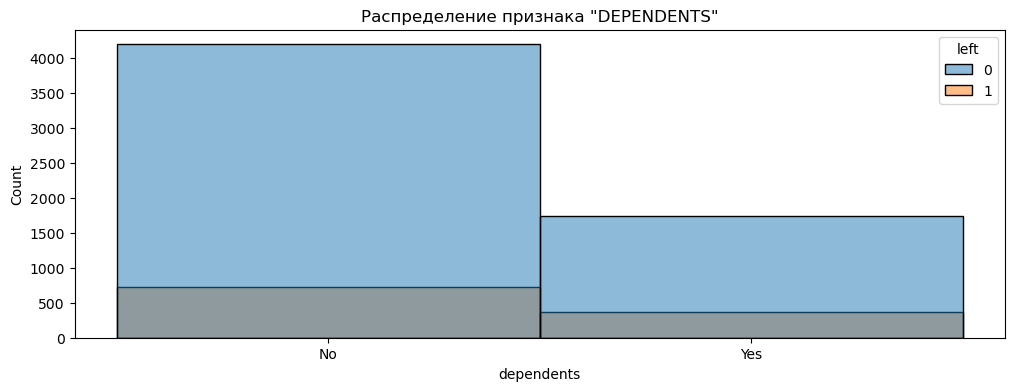

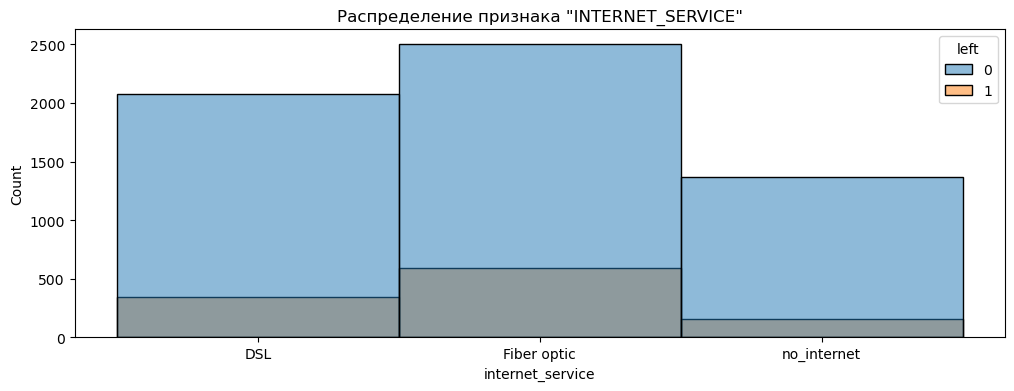

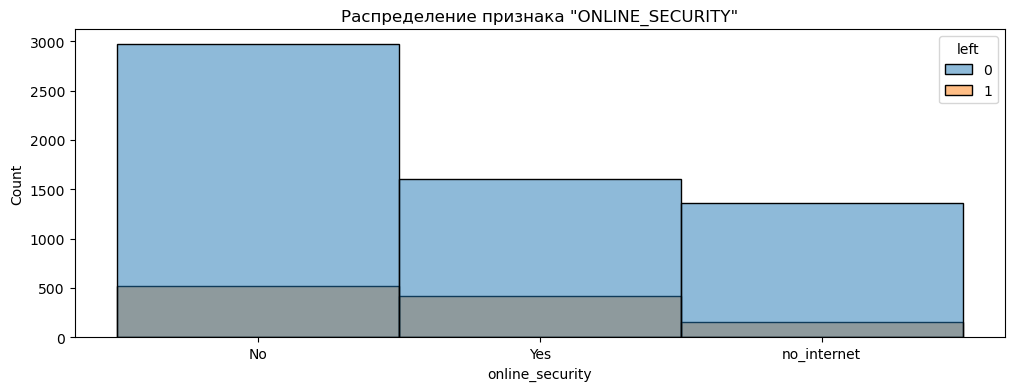

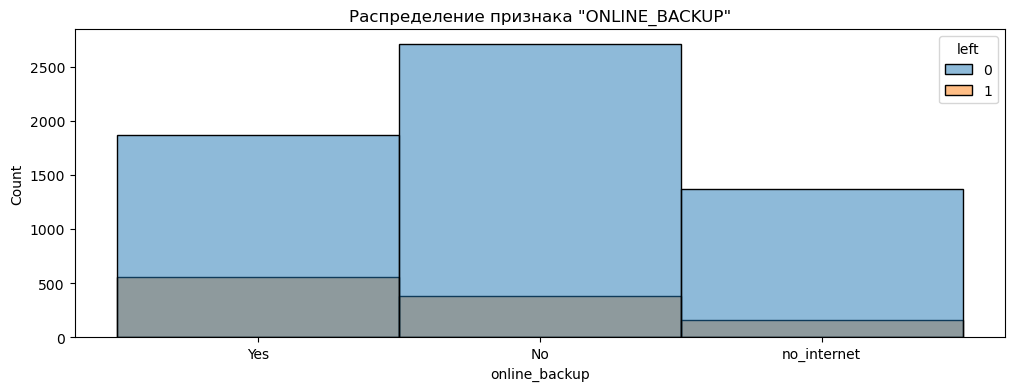

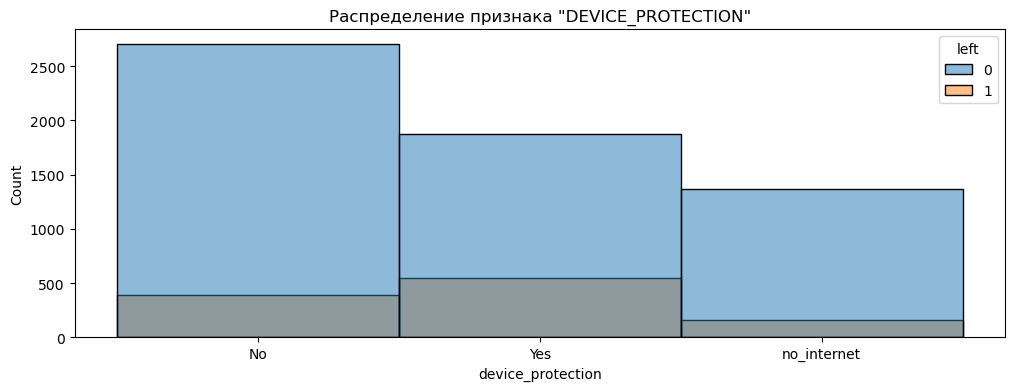

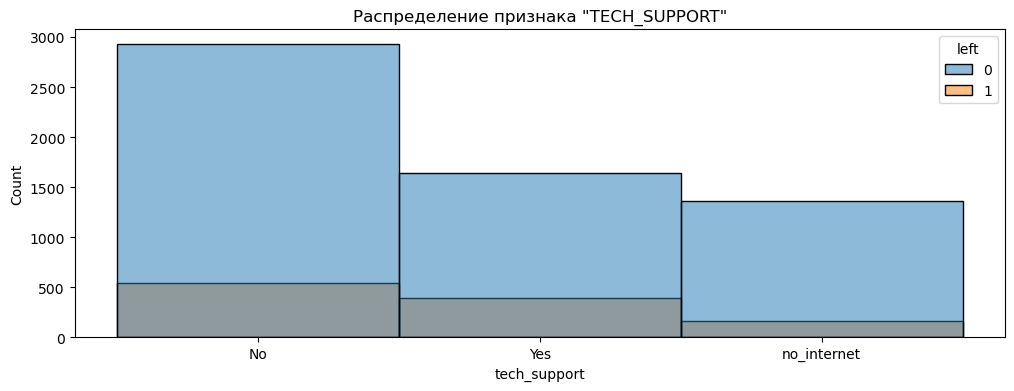

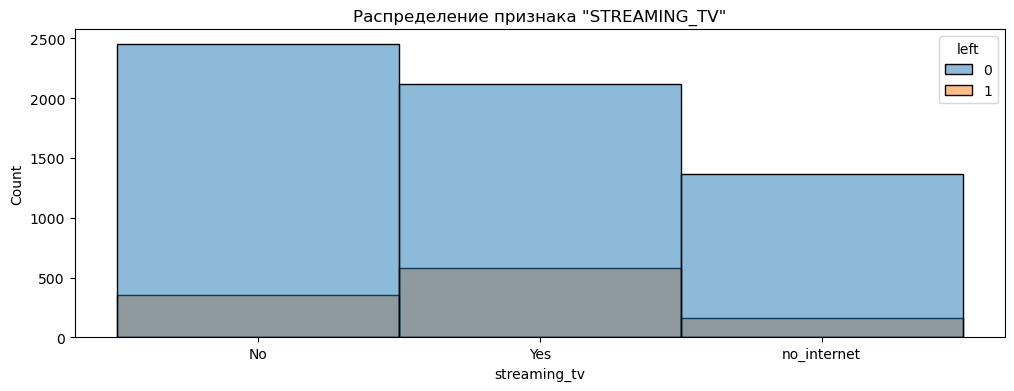

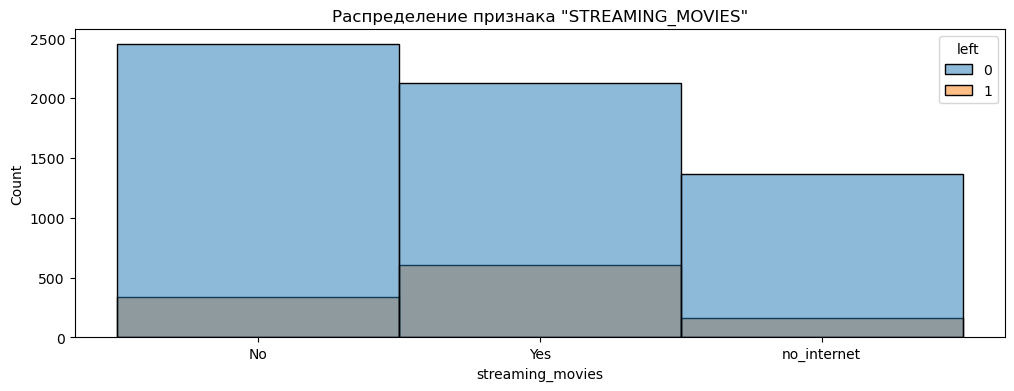

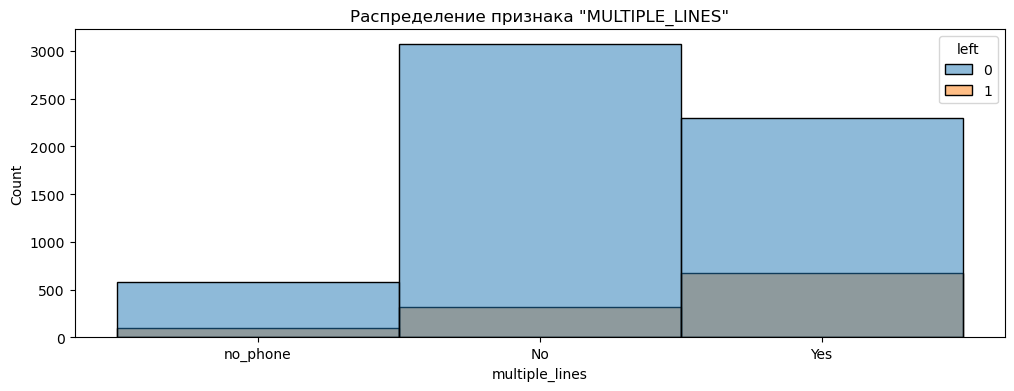

In [44]:
for column in cat_features:
    make_histplot(column)

По распределениям категориальных признаков видно, что, в целом, нет больших перекосов в распределениях между ушедшими и текущими клиентами.

Из графиков распределений можно сделать следующие выводы:
1. Большинство абонентов предпочитают платить ежемесячно, использовать электронный платежный документ и оплачивать электронным чеком.
2. Одинаковое распределение между мужчинами и женщинами, так же не видно какого-либо перекоса между текущими и ушедшими клиентами. Скорее всего можно будет исключить этот признак.
3. Отношение пенсионеров к не пенсионерам примерно 1 к 5.
4. Видно, что чуть больше клиентов не состоят в браке, но при этом можно заметить, что больше клиентов в браке прекратили пользоваться услугами компании.
5. Большая часть клиентов не имеет иждивенцев.
6. Видно, что распределения интернет услуг очень похожи между собой, предполагаю, что это связано, что клиенты предпочитают брать сразу несколько услуг. Скорее всего между этими признаками будет высокая мультиколлинеарность.
7. Из распределения телефонии можно сказать, что больше клиентов пользуется одноканальным телефоном, отношение многоканальных к одноканальным примерно 2 к 3.

## Новые признаки

Создадим новый признак, в котором будет суммироваться число интернет-услуг

In [45]:
internet_services = [
    'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv',
    'streaming_movies'
]

In [46]:
for service in internet_services:
    data.loc[data[service] == 'no_internet', service] = 0
    data.loc[data[service] == 'Yes', service] = 1
    data.loc[data[service] == 'No', service] = 0

In [47]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration,duration_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,0,1,0,0,0,0,no_phone,0,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,1,0,1,0,0,0,No,0,34,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,1,1,0,0,0,0,No,0,4,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,1,0,1,1,0,0,no_phone,0,45,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,0,0,0,0,0,0,No,0,5,153


In [48]:
data[internet_services] = data[internet_services].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   int64         
 14  online_b

In [49]:
data['internet_count'] = (
    data['online_security'] + data['online_backup'] +
    data['device_protection'] + data['tech_support'] +
    data['streaming_tv'] + data['streaming_movies']
)

data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration,duration_days,internet_count
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,0,1,0,0,0,0,no_phone,0,1,31,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,1,0,1,0,0,0,No,0,34,1036,2
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,1,1,0,0,0,0,No,0,4,123,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,1,0,1,1,0,0,no_phone,0,45,1371,3
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,0,0,0,0,0,0,No,0,5,153,0


### Матрица корреляции признаков
Построим тепловую матрицу корреляции признаков.

In [50]:
int_columns = ['monthly_charges', 'total_charges', 'duration', 'duration_days']

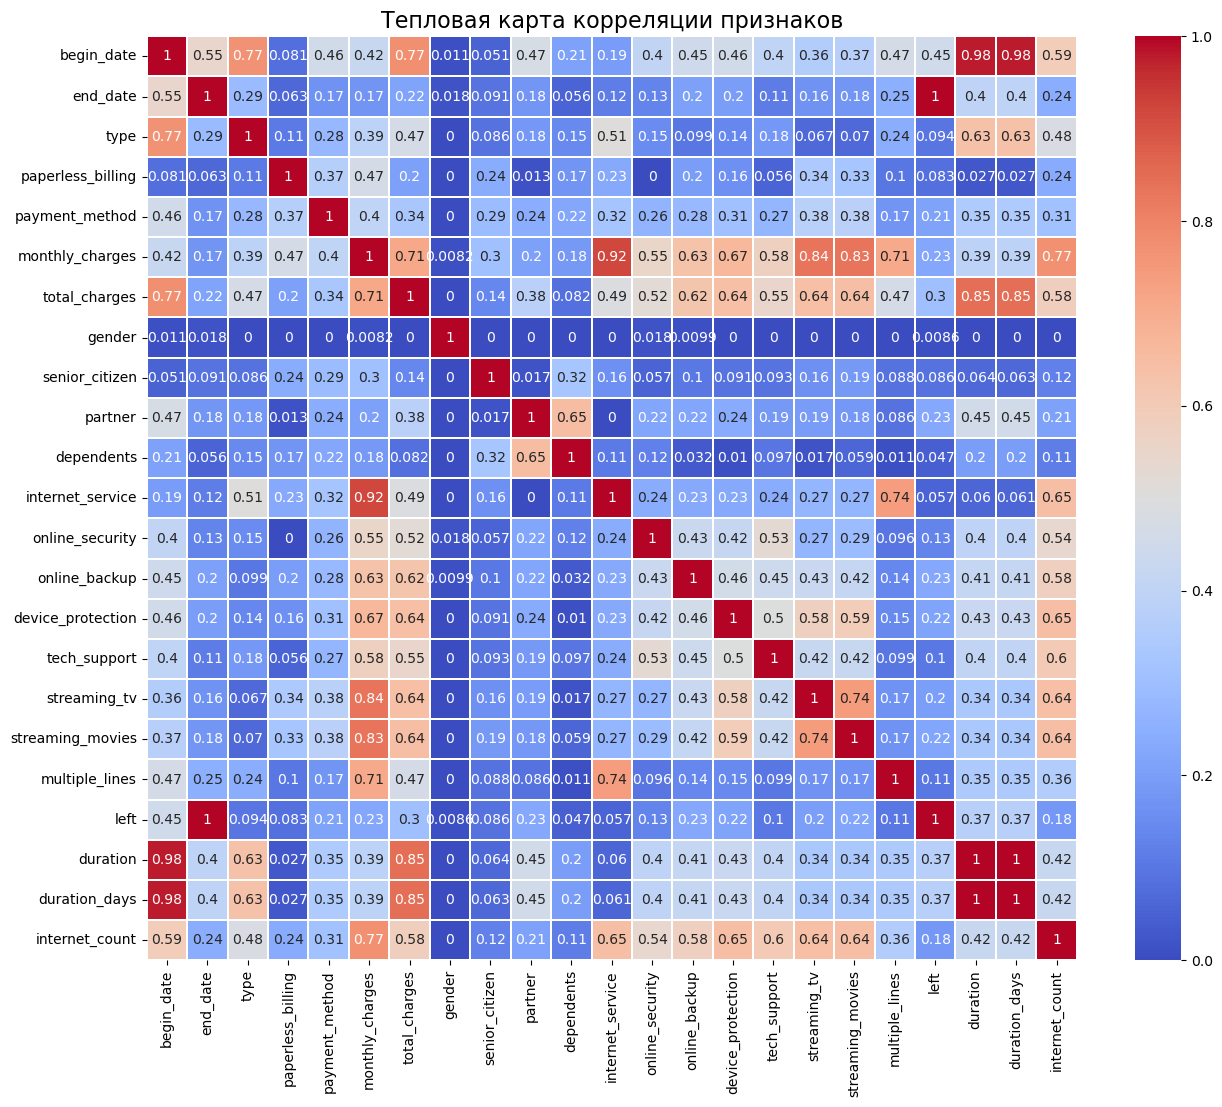

In [51]:
plt.figure(figsize=(15, 12))
plt.title('Тепловая карта корреляции признаков', fontsize=16)
sns.heatmap(
    data[data.columns[1:]].phik_matrix(interval_cols=int_columns),
    annot=True,
    linewidths=.2,
    cmap="coolwarm"
)
plt.show()

In [52]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration,duration_days,internet_count
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,0,1,0,0,0,0,no_phone,0,1,31,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,1,0,1,0,0,0,No,0,34,1036,2
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,1,1,0,0,0,0,No,0,4,123,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,1,0,1,1,0,0,no_phone,0,45,1371,3
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,0,0,0,0,0,0,No,0,5,153,0


По тепловой карте корреляции признаков видно:
1. Высокая мультиколлениарность между признаками `duration` и `duration_days`. Далее удалим признак `duration`.
2. Высокая мультиколлениарность между признаками `duration_days` и `total_charges`. Далее удалим признак `total_charges`.
3. Высокая мультиколлениарность между признаками `monthly_charges` и признаками `streaming_movies`, `streaming_tv` и `internet_service`.
4. Корреляция 1 между признаком `end_date` и целевым признаком. Нужно будет удалить этот признак т.к. был создан признак `duration_days`, так же нужно удалить признак `begin_date`.

### Удаление лишних признаков

Удалим из датасета признаки `customer_id`, `begin_date` и `end_date` которые не нужны для обучения модели машинного обучения. Так же удалим признак `gender` т.к. из распределения было видно, мужчин и женщин практичнское одинаковое количество и нет зависимости между признаком и целевым признаком. На предыдущем этапе выяснили, что наблюдается высокая мультиколлениарность между признаками, следует удалить эти признаки из датасета.

In [53]:
data = data.drop([
    'customer_id', 
    'begin_date', 
    'end_date', 
    'gender',
    'duration',
    'total_charges',
    'monthly_charges'
], axis=1)

In [54]:
data.head()

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration_days,internet_count
0,Month-to-month,Yes,Electronic check,0,Yes,No,DSL,0,1,0,0,0,0,no_phone,0,31,1
1,One year,No,Mailed check,0,No,No,DSL,1,0,1,0,0,0,No,0,1036,2
2,Month-to-month,Yes,Mailed check,0,No,No,DSL,1,1,0,0,0,0,No,0,123,2
3,One year,No,Bank transfer (automatic),0,No,No,DSL,1,0,1,1,0,0,no_phone,0,1371,3
4,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,0,0,0,0,0,0,No,0,153,0


In [55]:
data.shape

(7043, 17)

Построим тепловую матрицу корреляции признаков после удаления признаков с высокой мультиколлениарностью.

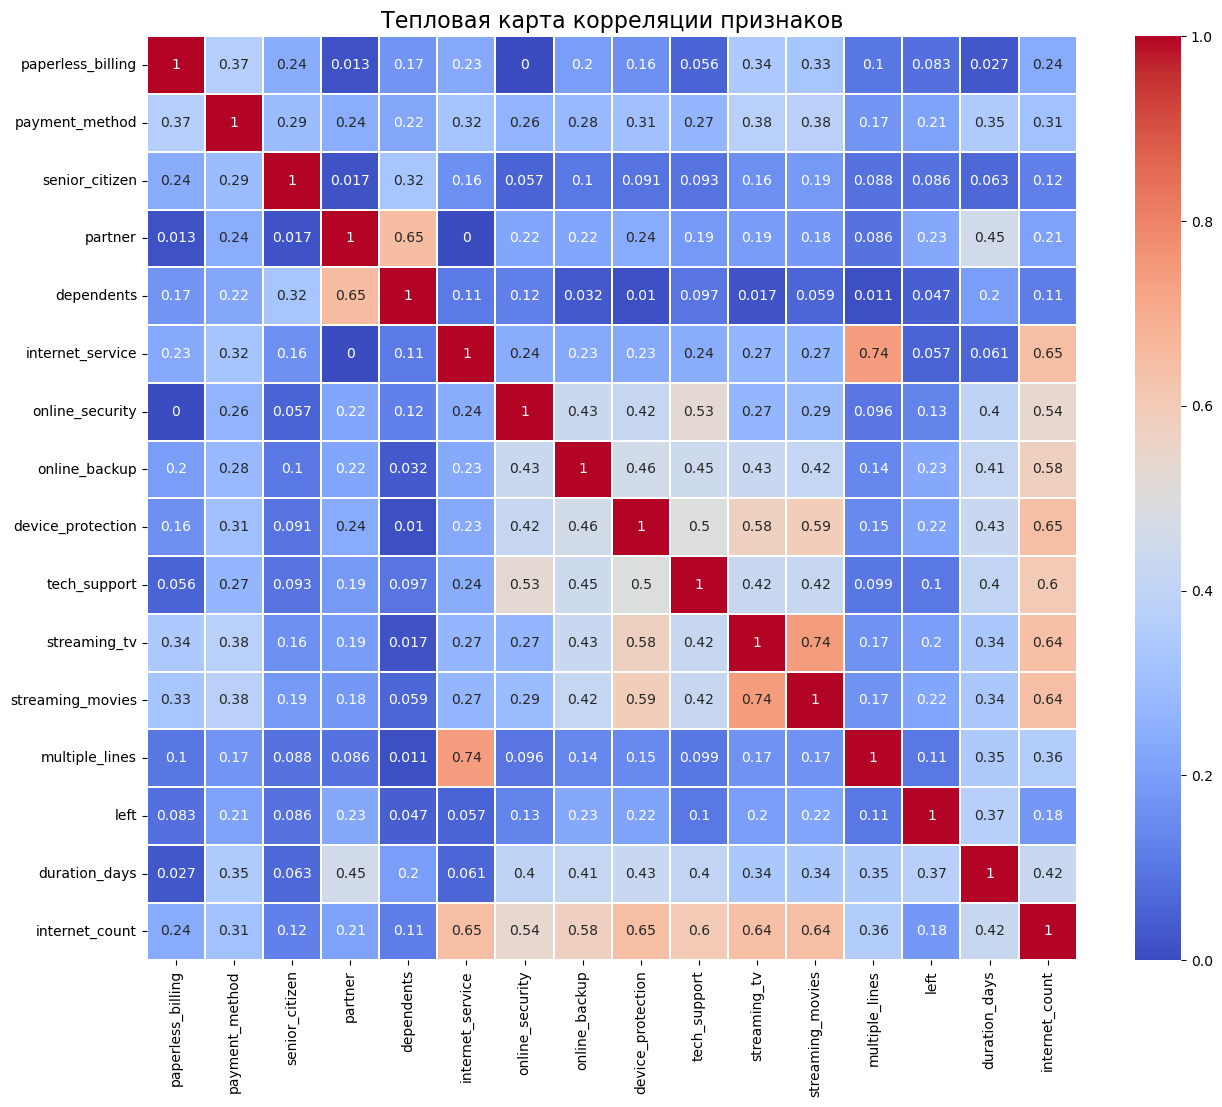

In [56]:
plt.figure(figsize=(15, 12))
plt.title('Тепловая карта корреляции признаков', fontsize=16)
sns.heatmap(
    data[data.columns[1:]].phik_matrix(interval_cols=int_columns),
    annot=True,
    linewidths=.2,
    cmap="coolwarm"
)
plt.show()

Признаков с высокой мультиколлениарностью не осталось

### Вывод по разделу

В ходе выполнения исследовательского анализа данных было:
- Были изменены типы данных в столбцах с датами и чиловыми признаками;
- Заполнены пропуски в данных;
- Объединение данных в один датасет для упрощения анализа данных;
- Был создан целевой признак `left`, так же создан признак `duration_days` (длительность договора в днях), так же был создан признак `internet_count` - количество используемых интернет-услуг;
- Заполнены пропуски, появившиеся в результате объединения датасетов;
- Проведен анализ данных.
- Проведен анализ мультиколениарности признаков

В результате анализа было выявлено:
1. Есть явный дисбаланс классов в выборке, с соотношением 1 к 6.5
2. Выявлено, что наибольшее количество клиентов уходят после 2 - 4 лет обслуживания и редко уходят после 5.5 лет обслуживания.
3. Среди всех абонентов большое количество новых клиентов (до 1 года).
4. У ушедших клиентов в среднем ежемесячные траты были выше.
5. Большинство абонентов предпочитают платить ежемесячно, использовать электронный платежный документ и оплачивать электронным чеком.
6. Одинаковое распределение между мужчинами и женщинами.
7. Отношение пенсионеров к не пенсионерам примерно 1 к 5.
8. Большая часть клиентов не имеет иждивенцев и не состоят в браке
9. Распределения интернет услуг очень похожи между собой и сильно коррелируют.
10. Высокая корреляция между ежемесячной платой и интернет услугами.

# Подготовка данных к обучению моделей

In [57]:
data.head()

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,left,duration_days,internet_count
0,Month-to-month,Yes,Electronic check,0,Yes,No,DSL,0,1,0,0,0,0,no_phone,0,31,1
1,One year,No,Mailed check,0,No,No,DSL,1,0,1,0,0,0,No,0,1036,2
2,Month-to-month,Yes,Mailed check,0,No,No,DSL,1,1,0,0,0,0,No,0,123,2
3,One year,No,Bank transfer (automatic),0,No,No,DSL,1,0,1,1,0,0,no_phone,0,1371,3
4,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,0,0,0,0,0,0,No,0,153,0


## Разделение датасетов

In [58]:
X = data.drop('left', axis=1)
y = data['left']

display(X.head())
y.head()

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_days,internet_count
0,Month-to-month,Yes,Electronic check,0,Yes,No,DSL,0,1,0,0,0,0,no_phone,31,1
1,One year,No,Mailed check,0,No,No,DSL,1,0,1,0,0,0,No,1036,2
2,Month-to-month,Yes,Mailed check,0,No,No,DSL,1,1,0,0,0,0,No,123,2
3,One year,No,Bank transfer (automatic),0,No,No,DSL,1,0,1,1,0,0,no_phone,1371,3
4,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,0,0,0,0,0,0,No,153,0


0    0
1    0
2    0
3    0
4    0
Name: left, dtype: int64

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.75,
    stratify=y,
    random_state=RANDOM_STATE
)

# Проверим правильность разделения данных
print(f'''
Тренировочная выборка:
Признаки - {X_train.shape}
Целевой признак - {y_train.shape}
Доля от общего датасета = {y_train.shape[0] / len(data)}

Тестовая выборка
Признаки - {X_test.shape}
Целевой признак - {y_test.shape}
Доля от общего датасета = {y_test.shape[0] / len(data)}

''')


Тренировочная выборка:
Признаки - (5282, 16)
Целевой признак - (5282,)
Доля от общего датасета = 0.7499645037626012

Тестовая выборка
Признаки - (1761, 16)
Целевой признак - (1761,)
Доля от общего датасета = 0.25003549623739885




## Масштабировние признаков

In [60]:
X_train.head()

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_days,internet_count
2857,Two year,No,Bank transfer (automatic),0,Yes,Yes,DSL,0,1,0,1,0,1,No,1432,3
4676,Month-to-month,Yes,Electronic check,0,No,Yes,no_internet,0,0,0,0,0,0,No,580,0
2291,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,0,0,0,0,1,0,Yes,245,1
3784,Month-to-month,Yes,Electronic check,1,No,No,Fiber optic,0,0,1,0,1,1,Yes,1187,3
698,One year,Yes,Bank transfer (automatic),1,Yes,Yes,Fiber optic,0,1,0,0,1,0,No,1432,2


In [61]:
numeric = [
    #'monthly_charges', 
    'duration_days'
]

In [62]:
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [63]:
X_train.head()

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_days,internet_count
2857,Two year,No,Bank transfer (automatic),0,Yes,Yes,DSL,0,1,0,1,0,1,No,0.780975,3
4676,Month-to-month,Yes,Electronic check,0,No,Yes,no_internet,0,0,0,0,0,0,No,-0.463170,0
2291,Month-to-month,Yes,Electronic check,0,No,No,Fiber optic,0,0,0,0,1,0,Yes,-0.952359,1
3784,Month-to-month,Yes,Electronic check,1,No,No,Fiber optic,0,0,1,0,1,1,Yes,0.423210,3
698,One year,Yes,Bank transfer (automatic),1,Yes,Yes,Fiber optic,0,1,0,0,1,0,No,0.780975,2


## Преобразование категориальных признаков

### One-hot encoding

Преобразуем данные с помощью One-hot encoding

In [64]:
#Создадим датасет для обучения логистической регресии
X_train = X_train #.copy() #.drop('monthly_charges', axis=1)
X_test = X_test #.copy() #.drop('monthly_charges', axis=1)

In [65]:
ohe_features =[
    'type', 'paperless_billing', 'payment_method', 'senior_citizen',
    'partner', 'dependents', 'internet_service', 'multiple_lines', 'internet_count'
]

In [66]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, dtype='int')

In [67]:
X_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.fit_transform(X_train[ohe_features])
X_train = X_train.drop(ohe_features, axis=1)

X_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test[ohe_features])
X_test = X_test.drop(ohe_features, axis=1)

In [68]:
X_train.head()

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,duration_days,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_1,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_no_internet,multiple_lines_Yes,multiple_lines_no_phone,internet_count_1,internet_count_2,internet_count_3,internet_count_4,internet_count_5,internet_count_6
2857,0,1,0,1,0,1,0.780975,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
4676,0,0,0,0,0,0,-0.463170,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2291,0,0,0,0,1,0,-0.952359,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0
3784,0,0,1,0,1,1,0.423210,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0
698,0,1,0,0,1,0,0.780975,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0


In [69]:
X_train.shape

(5282, 26)

### Ordinal encoding

Для обучения моделей на основе деревьев создадим отдельный датасет, в котором будут все признаки.
 
Категориальные признаки преобразуем с помощью OrdinalEncoding

In [70]:
# oe_features = [
#     'type', 'paperless_billing', 'payment_method',
#     'senior_citizen', 'partner', 'dependents', 'internet_service',
#     'multiple_lines'
# ]
# 
# encoder_oe = OrdinalEncoder(dtype='int')

In [71]:
# X_train[oe_features] = encoder_oe.fit_transform(X_train[oe_features])
# X_test[oe_features] = encoder_oe.transform(X_test[oe_features])

In [72]:
# X_train.head()

# Обучение моделей машинного обучения

## LogisticRegressionCV

In [73]:
model_lr = LogisticRegressionCV( 
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    
)
model_lr.fit(X_train, y_train)

LogisticRegressionCV(random_state=70823, scoring='roc_auc')

In [74]:
print(f'Значения ROC-AUC: {cross_val_score(model_lr, X_train, y_train, cv=5).mean()}')

Значения ROC-AUC: 0.7661918328500188


## RandomForestClassifier

In [75]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

In [76]:
param_grad_rf = {
    'max_depth': range(1, 11, 1),
    'n_estimators': range(10, 101, 10),
    'min_samples_split': range(2, 11, 1)
}

grid_search_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grad_rf,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    cv=5
)

rf_pred = grid_search_rf.fit(X_train, y_train)

In [77]:
print(f'''
Лучшая оценка AUC_ROC: {rf_pred.best_score_}
Лучшие параметры модели: {rf_pred.best_params_}
''')


Лучшая оценка AUC_ROC: 0.8247683229565672
Лучшие параметры модели: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 8}



## LGBMClassifier

In [78]:
%%time
model_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1
)

param_grid_lgbm = {
    'max_depth': range(1, 6, 1),
    'n_estimators': range(10, 1001, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'boosting_type': ['gbdt', 'dart'],
}

grid_search_lgbm = RandomizedSearchCV(
    model_lgbm,
    param_distributions=param_grid_lgbm,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)

lgbm_pred = grid_search_lgbm.fit(X_train, y_train)

CPU times: user 590 ms, sys: 148 ms, total: 738 ms
Wall time: 2.45 s


In [79]:
print(f'''
Лучшая оценка AUC_ROC: {lgbm_pred.best_score_}
Лучшие параметры модели: {lgbm_pred.best_params_}
''')


Лучшая оценка AUC_ROC: 0.9207855701007543
Лучшие параметры модели: {'n_estimators': 490, 'max_depth': 2, 'learning_rate': 0.2, 'boosting_type': 'gbdt'}



## CatBoostClassifier

In [80]:
model_cb = CatBoostClassifier(
    random_state=RANDOM_STATE,
    eval_metric='AUC',
    logging_level = 'Verbose',
    iterations=2000,
    task_type='CPU'
)

param_grid_cb = {
    'max_depth': range(1, 6, 1),
    'n_estimators': range(10, 1001, 10),
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'auto_class_weights': ['Balanced', 'SqrtBalanced'],
    'score_function': ['SolarL2', 'Cosine', 'NewtonL2', 'NewtonCosine', 'LOOL2', 'SatL2', 'L2']
}

grid_search_cb = model_cb.randomized_search(
    param_grid_cb,
    X=X_train,
    y=y_train,
    cv=5
)

0:	test: 0.6991474	best: 0.6991474 (0)	total: 61ms	remaining: 10.3s
1:	test: 0.7502279	best: 0.7502279 (1)	total: 67.1ms	remaining: 5.63s
2:	test: 0.7985630	best: 0.7985630 (2)	total: 69.9ms	remaining: 3.89s
3:	test: 0.8209335	best: 0.8209335 (3)	total: 73.4ms	remaining: 3.04s
4:	test: 0.8259316	best: 0.8259316 (4)	total: 76.7ms	remaining: 2.53s
5:	test: 0.8328262	best: 0.8328262 (5)	total: 81ms	remaining: 2.21s
6:	test: 0.8358912	best: 0.8358912 (6)	total: 86.2ms	remaining: 2.01s
7:	test: 0.8396031	best: 0.8396031 (7)	total: 89.5ms	remaining: 1.81s
8:	test: 0.8384712	best: 0.8396031 (7)	total: 91.2ms	remaining: 1.63s
9:	test: 0.8380448	best: 0.8396031 (7)	total: 93.6ms	remaining: 1.5s
10:	test: 0.8386770	best: 0.8396031 (7)	total: 96.5ms	remaining: 1.4s
11:	test: 0.8397611	best: 0.8397611 (11)	total: 99.4ms	remaining: 1.31s
12:	test: 0.8406836	best: 0.8406836 (12)	total: 103ms	remaining: 1.24s
13:	test: 0.8416759	best: 0.8416759 (13)	total: 106ms	remaining: 1.19s
14:	test: 0.8421169	b

In [81]:
print(f'''
Лучшая оценка AUC_ROC: 0.9328027752
Лучшие параметры модели: {model_cb.get_params()}
''')


Лучшая оценка AUC_ROC: 0.9328027752
Лучшие параметры модели: {'iterations': 170, 'logging_level': 'Verbose', 'eval_metric': 'AUC', 'task_type': 'CPU', 'random_state': 70823, 'depth': 2, 'learning_rate': 0.5, 'score_function': 'L2', 'auto_class_weights': 'Balanced'}



## Тестирование модели

В результате обучения 4-х моделей классификации, наилучей моделью оказалась модель **CatBoostClassifier** с оценкой на кросс-валидации метрики ROC-AUC = 0.9328027752

Проведем тестирование модели на тестовой выборке.

In [82]:
predict_probabilities = model_cb.predict_proba(X_test)
print('Значение ROC-AUC на тестовой выборке:', roc_auc_score(y_test, predict_probabilities[:, 1]))
print('Значение Accuracy на тестовой выборке:', accuracy_score(y_test, model_cb.predict(X_test)))

Значение ROC-AUC на тестовой выборке: 0.9229780986173987
Значение Accuracy на тестовой выборке: 0.8648495173197047


Значение метрики **Accuracy** составляет - 0.864, это означает, что модель правильно предсказывает 86.4% объектов из нашей выборки, но эта метрика не совсем репрезентативна, т.к. она не оценивает дисбаланс классов,  и так же нужно смотеть на матрицу ошибок, т.к. модель может предсказывать какой-то класс более точно и уже это нужно соотносить с бизнес-целями компании.

## ROC-Кривая

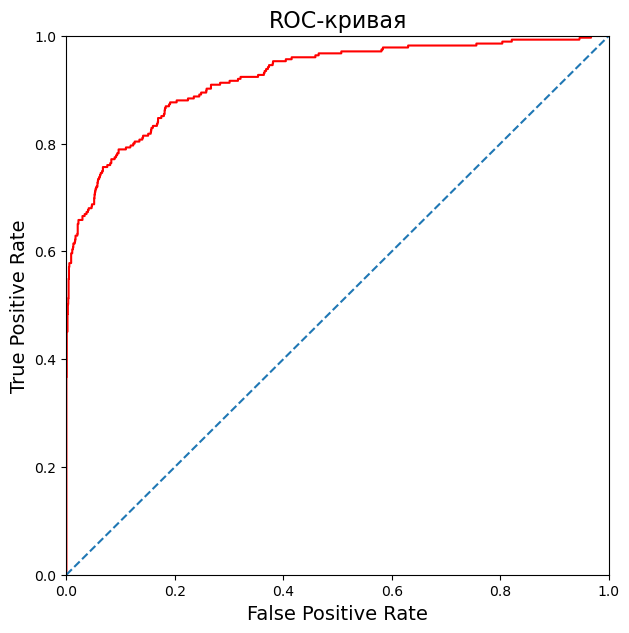

In [83]:
fpr, tpr, threshplds = roc_curve(y_test, predict_probabilities[:, 1])

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='r')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('ROC-кривая', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.show() 

## Матрица ошибок

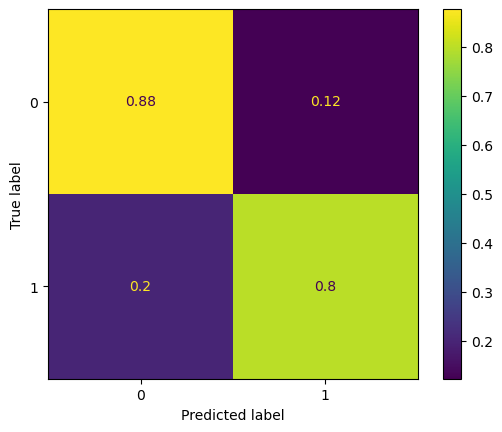

In [84]:
cm = confusion_matrix(y_test, model_cb.predict(X_test), normalize='true')
cm_display = ConfusionMatrixDisplay(cm).plot()

По матрице ошибок работы модели можно увидеть:
1. Модель очень хорошо предсказывет истинно отрицательные ответы - 88%, т.е тех клиентов, которые не собираются перестать пользоваться услугами компании
2. В 12% случаях модель неверно предсказывает клиентов которые не уходят как клиентов, которые скоро прекратят пользоваться услугами компании.
3. В 80% случаев модель правильно предсказывает клиентов, которые могут скоро уйти из компании (истинно положительные объекты).
4. В 20% случаев модель ошибается и предсказывает, что клиент не уйдет.

В целом можно собрать дополнительные данные для обучения моделей и постараться увеличить количество предсказаний истинно положительных объектов (клиентов, которые хотят уйти), чтобы именно именно им были предложены доплнительные промокоды или лучшие тарифы, так можно будет сократить издержки.

## Важность признаков

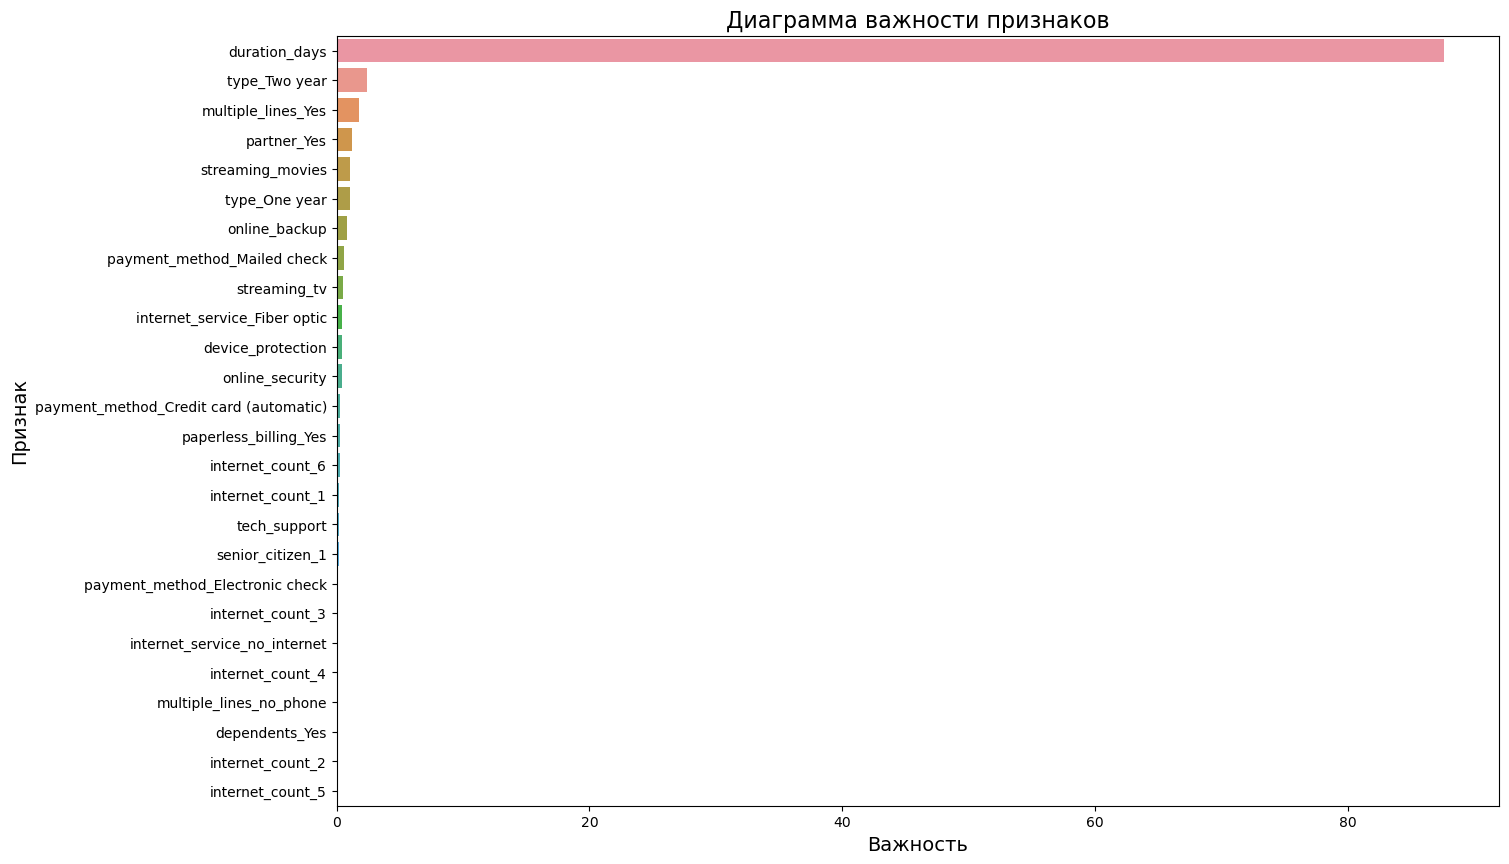

In [85]:
feature_importance = pd.DataFrame(data={
    'Features': X_train.columns,
    'Value': model_cb.get_feature_importance()
})

feature_importance = feature_importance.sort_values(by='Value', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(x=feature_importance['Value'], y=feature_importance['Features'])
plt.title('Диаграмма важности признаков', fontsize=16)
plt.xlabel('Важность', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.show()

Из диаграммы важности признаков видно, что наибольший вклад в обучение модели вносят признаки (топ-5):
1. `duration_days`
2. `type_Two year`
3. `multiple_lines_Yes`
4. `partner_Yes`
5. `streaming_movies`

## Вывод по разделу

В части решения задачи были выполнены следующие работы:
1. Созданы новые признаки, такие как длительность контракта в днях и количество интернет услуг.
2. Удалены лишние признаки.
3. Были выделены обучающие признаки и целевой признак. Также выделили тренировочную и тестовую модель.
4. Были масштабированы признаки.
5. Для обучения логистической регресии был создан отдельная тренировочная и тестовая выборки, в которой были удалены признаки с высокой мультиколлениарностью и были преобразованы категориальные признаки с помощью **one-hot encoding**. 
6. Для обучения моделей на основе деревьев категориальные признаки были преобразованы с помощью **ordinal encoding**.
7. Были обучены 4 модели машинного обучения: LogisticRegressionCV, RandomForestClassifier, LGBMClassifier, CatBoostClassifier. Наилучшей моделью оказалась **CatBoostClassifier**.
8. Была протестирована модель **CatBoostClassifier** на тестовой выборке. Значение ROC AUC на тестовой выборке: 0.9137599412700356.
9. Построена ROC-кривая, матрица ошибок и проведена оценка важности признаков.

# Отчет

Нам были переданные данные от телеком компании для построения системы прогнозирования оттока клиентов, заказчик в лице компании "Ниединогоразрыва.ком" хочет решить проблему ухода клиентов к другому провайдеру интернета и телефонии. При выявлении клиентов, которые могут планировать закрыть договор, этим клиентам будут предложены промокоды и специальные условия для их удержания. Построение системы прогнозирования оттока клиентов благоприятно скажется на финансовых показателях компании, т.к. издержки на привлечение новых клиентов гораздо больше, чем издержки на удержание старых.

Заказчиком были предоставлены следующие данные:
1. `contract` - общая информация по договору для каждого клиента
2. `personal` - персональные данные клиентов
3. `internet` - информация об интернет-услугах
4. `phone` - информация об услугах телефонии


### Ключевые шаги работы над проектом
В ходе работы были проделанные следующие работы:
1. Загрузка, сохранение и знакомство с общей информацией по данным
2. Исследовательский анализ данных
3. Подготовка данных к обучению моделей
4. Обучение моделей машинного обучения
5. Тестирование наилучшей модеои и анализ результатов

Все запланированные работы по выполнению проекта были выполнены.

### Сложности, возникшие при работе с проектом
Изначально была посчитана длительность контракта в месяцах, но это не позволяло получить высокие результаты при обучении моделей, при создании признака длительности в днях эта проблема была решена.

### Итоговый список признаков для обучения их обработки
Для обучения итоговой модели использовались следующие признаки:

Непрерывные признаки:
- `monthly_charges` - жемесячные траты на услуги по договору;
- `duration_days` - длительность договора в днях
- `internet_count` - количество интернет-услуг

Категориальные признаки: 
- `type` - тип оплаты;
- `paperless_billing` - тип электронного платежного документа;
- `payment_method` - способ оплаты; 
- `senior_citizen` - наличие пенсионного статуса по возрасту;
- `partner` - наличие супруга(и);
- `dependents` - наличие иждивенцев;
- `internet_service` - тип подключения интернета;
- `online_security` - блокировка небезопасных сайтов;
- `online_backup` - облачное хранилище файлов для резервного копирования данных ;
- `device_protection` - антивирус;
- `tech_support` - выделенная линия технической поддержки;
- `streaming_tv` - стриминговое телевидение;
- `streaming_movies` - каталог фильмов;
- `multiple_lines`- мультиканальная линия.

Непрерывные признаки были масштабированы с помощью `StandardScaler`, преобразование категориальных признаков было проведено с помощью `One-Hot Encoding`

### Лучшая модель
Было обучено 4 модели машинного обучения и получены значения ROC-AUC на кросс-валидации:

|   | Model ML                  | ROC-AUC (cross-avlidation)|
|--:|:--------------------------|:--------------------------|
| 1 | LogisticRegressionCV      | 0.7661        | 
| 2 | RandomForestClassifier    | 0.8247        |
| 3 | LGBMClassifier            | 0.9207        |
| 4 | CatBoostClassifier        | 0.9328        |

В результате проверки работы моделей на кросс-валидации наилучая модель - CatBoostClassifier.

**Оценка AUC_ROC на кросс-валидации: 0.9328027752**

**Параметры модели:** 
- 'iterations': 170 
- 'logging_level': 'Verbose' 
- 'eval_metric': 'AUC'
- 'task_type': 'CPU' 
- 'random_state': 70823
- 'depth': 2
- 'learning_rate': 0.5
- 'score_function': 'L2'
- 'auto_class_weights': 'Balanced'

### Результаты тестирования лучшей модели
В результате тестирования модели CatBoostClassifier были получены следующие значения метрик:
- Значение ROC-AUC на тестовой выборке: 0.9229780986173987
- Значение Accuracy на тестовой выборке: 0.8648495173197047

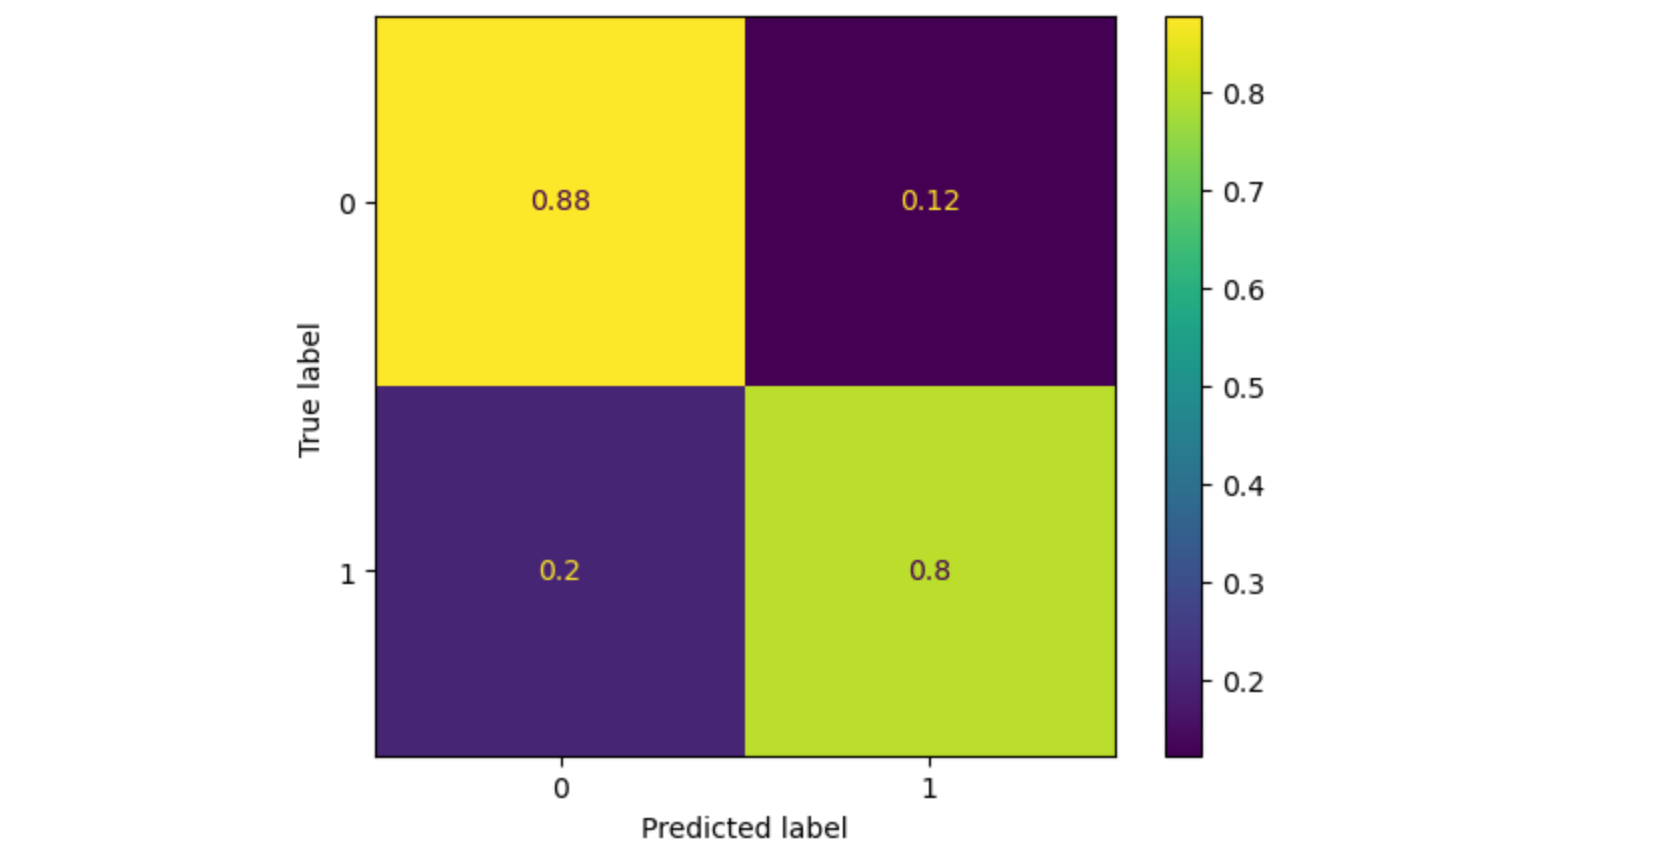
При анализе матрицы ошибок работы модели можно увидеть, что обученная модель очень хорошо предсказывет истинно отрицательные ответы (0,88), т.е тех клиентов, которые не собираются перестать пользоваться услугами компании.
В 80% случаев модель правильно предсказывает клиентов, которые могут скоро уйти из компании (истинно положительные объекты), В 20% случаев модель ошибается и предсказывает, что клиент не уйдет.

Можно собрать дополнительные данные для обучения моделей и постараться увеличить количество предсказаний истинно положительных объектов (клиентов, которые хотят уйти), чтобы именно именно им были предложены доплнительные промокоды или лучшие тарифы, так можно будет сократить издержки.

**Важность признаков**
Была проведена оценка важности признаков, ниже представлены наиболее важные из них:
1. `duration_days`
2. `type_Two year`
3. `multiple_lines_Yes`
4. `partner_Yes`
5. `streaming_movies`

**Итоговая модель на тестовых данных показала значение метрики ROC-AUC - 0.9229 и Accuracy - 0.8648.
Заказчиком было поставлено уловие, что метрика должна быть выше значения 0.85, мы добились необходимого значения метрики и данную модель можно далее передавать в дальнейшую работу для встраивания её в сервис предсказания оттока клментов**

Следует отметить, что для оценки модели предпочительнее использовать метрику **ROC-AUC**, нежели **Accuracy**, т.к. метрика **ROC-AUC** не подвержена влиянию дисбаланса классов.